In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2
import pathlib
import os
from sklearn.metrics import classification_report, accuracy_score
from keras.metrics import Precision, Recall
from sklearn import svm
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

In [7]:
dataset_folder = os.path.join("/kaggle/input/plant-pathology-2020-fgvc7")
train = pd.read_csv(os.path.join(dataset_folder, 'train.csv'))
test = pd.read_csv(os.path.join(dataset_folder, 'test.csv'))

In [8]:
image_dataset = pathlib.Path(os.path.join(dataset_folder, 'images'))
listimages = list(image_dataset.glob('*.*'))

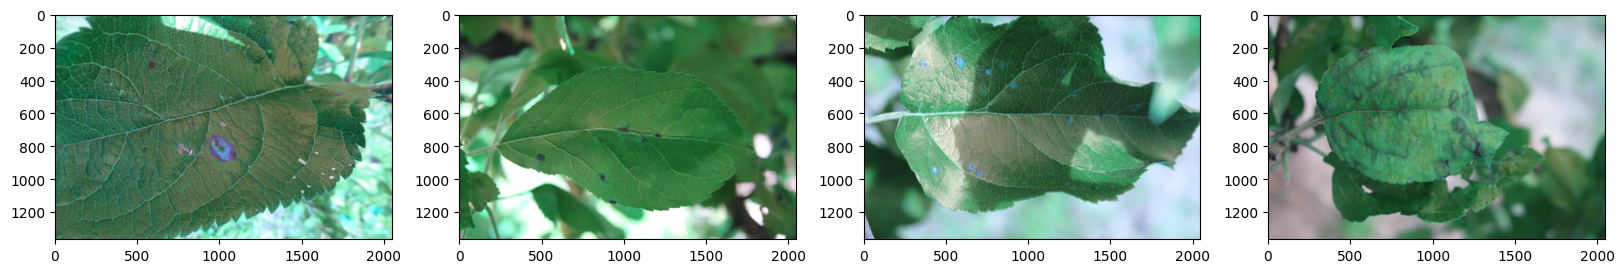

In [9]:
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = cv2.imread(str(listimages[i]))
    plt.imshow(img)
plt.savefig('sample1.png')
plt.show()

In [10]:
images_id_csv = train['image_id']
healthy_csv = train['healthy']
multiple_diseases_csv = train['multiple_diseases']
rust_csv = train['rust']
scab_csv = train['scab']

In [11]:
images = []
labels = []
for index,  values in enumerate(images_id_csv):
    img = cv2.imread(os.path.join(dataset_folder, 'images', '{}.jpg'.format(values)))
    img = cv2.resize(img, (100, 100))
    img = img/255
    labels.append([healthy_csv[index], multiple_diseases_csv[index], rust_csv[index], scab_csv[index]])
    images.append(img)

# Test set

In [12]:
images_id_csv_test = test['image_id']
#healthy_csv_test  = test['healthy']
#multiple_diseases_csv_test  = test['multiple_diseases']
#rust_csv_test  = test['rust']
#scab_csv_test  = test['scab']

In [13]:
images_test = []
labels_test = []
for index,  values in enumerate(images_id_csv_test):
    img_test = cv2.imread(os.path.join(dataset_folder, 'images', '{}.jpg'.format(values)))
    img_test = cv2.resize(img_test, (100, 100))
    img_test = img_test/255
    images_test.append(img_test)

In [14]:
images_test_p = []
for i in images_test:
    images_test_p.append(np.reshape(i, (100, 100, 3)))

In [15]:
images_test_p = np.asarray(images_test_p)

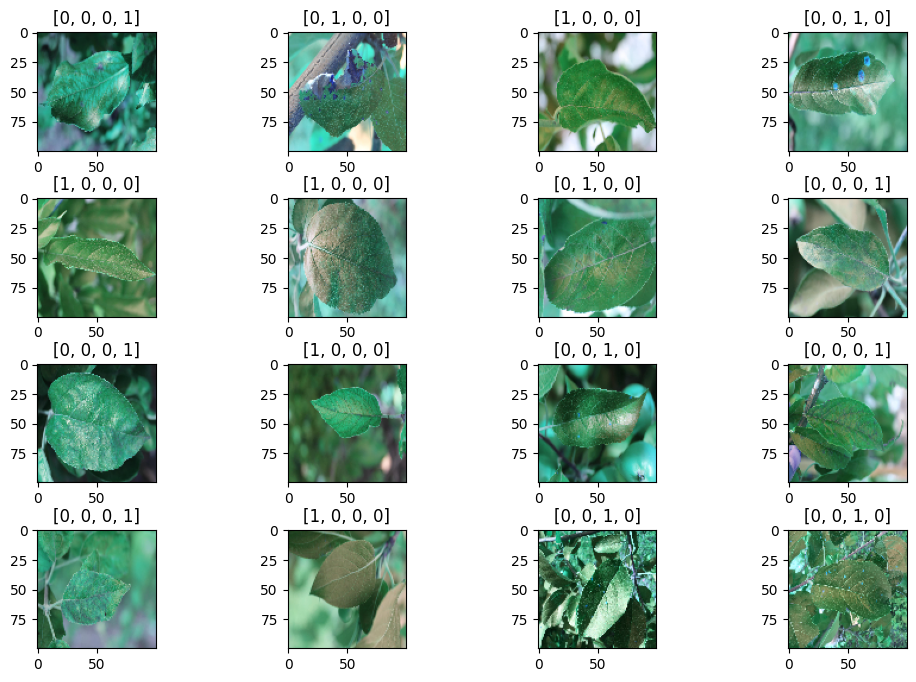

In [16]:
plt.figure(figsize = (12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
plt.savefig('sample_labels.png')
plt.show()

In [17]:
img_data_g = tf.keras.preprocessing.image.ImageDataGenerator(
             rotation_range = 0.35,#對圖片旋轉
             zoom_range=0.2,#對長或寬進行放大或縮小
             horizontal_flip=True,#對圖片水平翻轉
             vertical_flip=True, #對圖片平行翻轉
             shear_range=0.2,#固定X(或Y)，將Y(或X)依比例平移 
             width_shift_range=0.15,#圖片左右平移
             height_shift_range=0.15,#圖片上下平移
             rescale=None)

In [18]:
images_after_aug = []
labels_after_aug = []
for index, image in enumerate(images):
    for i in range(10):
        img = img_data_g.flow(np.reshape(image, (1, 100, 100, 3))).next()
        images_after_aug.append(np.reshape(img, (100, 100, 3)))
        labels_after_aug.append(labels[index])
labels = np.asarray(labels_after_aug)
images = np.asarray(images_after_aug)

In [19]:
images.shape

(18210, 100, 100, 3)

/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


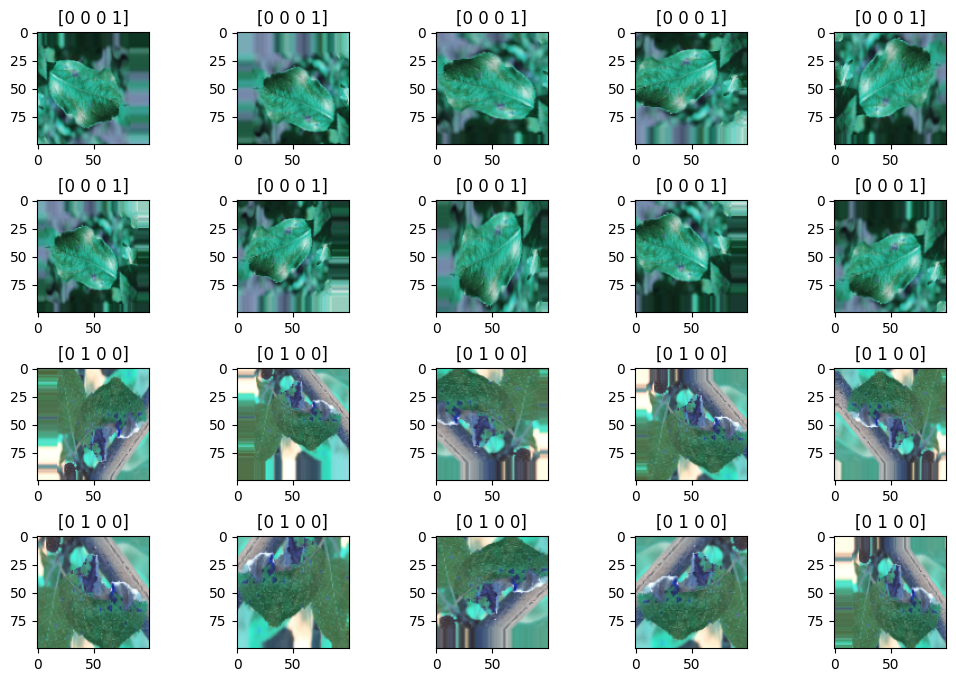

In [22]:
plt.figure(figsize = (12, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.savefig('sample_after_aug.png')
plt.show()

In [ ]:
d = tf.keras.applications.DenseNet121(include_top = False, input_shape = (100, 100, 3), pooling = None, weights = 'imagenet')
for i in d.layers:
    i.trainable = True

In [19]:
m = tf.keras.layers.GlobalAveragePooling2D()(d.output)
m = tf.keras.layers.Dropout(0.5)(m)
m = tf.keras.layers.Dense(128, activation = 'sigmoid')(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(256, activation = 'relu')(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(512, activation = 'relu')(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(4, activation = 'softmax')(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)
m.compile(optimizer = tf.keras.optimizers.Adam(0.001),
          loss = 'categorical_crossentropy',
          metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 1)

In [21]:
x_train.shape

(15478, 100, 100, 3)

In [22]:
x_test.shape

(2732, 100, 100, 3)

In [23]:
y_train.shape

(15478, 4)

In [24]:
y_test.shape

(2732, 4)

In [25]:
y_train

array([[1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [26]:
history = m.fit(x_train, y_train, epochs = 30, batch_size = 32,
                callbacks = [
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, mode = 'min',
                                                  patience= 1),
                    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min', restore_best_weights = True)
                ])

Epoch 1/30
484/484 [==============================] - 110s 88ms/step - loss: 0.5443 - accuracy: 0.8212 - precision: 0.8646 - recall: 0.7737 - lr: 0.0010
Epoch 2/30
484/484 [==============================] - 43s 89ms/step - loss: 0.3305 - accuracy: 0.8987 - precision: 0.9205 - recall: 0.8781 - lr: 0.0010
Epoch 3/30
484/484 [==============================] - 41s 84ms/step - loss: 0.2643 - accuracy: 0.9165 - precision: 0.9361 - recall: 0.8987 - lr: 0.0010
Epoch 4/30
484/484 [==============================] - 43s 89ms/step - loss: 0.2325 - accuracy: 0.9273 - precision: 0.9410 - recall: 0.9154 - lr: 0.0010
Epoch 5/30
484/484 [==============================] - 41s 84ms/step - loss: 0.1991 - accuracy: 0.9351 - precision: 0.9465 - recall: 0.9250 - lr: 0.0010
Epoch 6/30
484/484 [==============================] - 40s 83ms/step - loss: 0.1867 - accuracy: 0.9408 - precision: 0.9511 - recall: 0.9316 - lr: 0.0010
Epoch 7/30
484/484 [==============================] - 40s 84ms/step - loss: 0.1640 - ac

In [27]:
tf.keras.models.save_model(m, 'my_model_v2.hdf5')

In [26]:
history = keras.models.load_model('/kaggle/input/modelv2/my_model_v2.hdf5')
history.compile

<bound method Model.compile of <keras.engine.functional.Functional object at 0x784e6dbafa60>>

In [27]:
plt.figure(figsize = (20, 6))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['precision'], label = "precision")
plt.plot(history.history['recall'], label = "recall")
plt.plot(history.history['loss'], label = "loss")
plt.savefig('history.png')
plt.legend()

TypeError: 'NoneType' object is not subscriptable

<Figure size 2000x600 with 0 Axes>

In [28]:
m.evaluate(x_test, y_test, batch_size= 32)

NameError: name 'm' is not defined

In [84]:
y_pred = history.predict(x_test)
#y_pred = np.argmax(y_pred, axis = 1)

86/86 [==============================] - 2s 19ms/step


In [85]:
y_pred

array([[9.9999940e-01, 2.7734053e-08, 3.1035796e-08, 5.1369034e-07],
       [9.9999976e-01, 3.4372906e-08, 3.9126665e-08, 2.5674987e-07],
       [1.8681558e-08, 3.5893262e-07, 9.9297888e-12, 9.9999964e-01],
       ...,
       [9.9999976e-01, 3.2469831e-08, 3.5460030e-08, 2.3727870e-07],
       [3.6296080e-06, 7.6067729e-05, 2.2706814e-08, 9.9992025e-01],
       [4.8765910e-06, 3.8254538e-04, 8.9428511e-08, 9.9961251e-01]],
      dtype=float32)

In [32]:
y_test = np.argmax(y_test, axis = 1)

In [33]:
cnn_standard_acc = accuracy_score(y_pred, y_test)
print(cnn_standard_acc)

0.9806002928257687


In [34]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       795
           1       0.80      0.91      0.85       124
           2       1.00      0.99      0.99       922
           3       0.98      0.98      0.98       891

    accuracy                           0.98      2732
   macro avg       0.94      0.97      0.95      2732
weighted avg       0.98      0.98      0.98      2732



In [29]:
sub = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')
probs_RESNET = history.predict(images_test_p)
sub.loc[:, 'healthy':] = probs_RESNET
sub.to_csv('submission.csv', index=False)
sub.head()

57/57 [==============================] - 8s 26ms/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.617932e-08,4.262857e-07,9.999995e-01,1.251277e-08
1,Test_1,8.610019e-09,1.409309e-07,9.999999e-01,6.218774e-09
2,Test_2,9.136397e-09,1.595790e-07,4.977646e-12,9.999999e-01
3,Test_3,9.999994e-01,3.395650e-08,5.762803e-08,5.132697e-07
4,Test_4,8.567873e-07,7.952695e-05,9.999193e-01,3.859497e-07


In [ ]:
def generate_confusion_matrix(y_pred, y_test):
    c = tf.math.confusion_matrix(y_pred, y_test)
    sns.heatmap(c, annot=True)

In [ ]:
generate_confusion_matrix(y_pred, y_test)

# CNN+RF, XGB, SVM

In [31]:
new_model = tf.keras.models.Model(
    history.input, history.output
)

In [34]:
features_x_train = new_model.predict(x_train)

484/484 [==============================] - 11s 18ms/step


In [35]:
features_x_test = new_model.predict(x_test)

86/86 [==============================] - 3s 31ms/step


In [36]:
features_x_train.shape

(15478, 4)

In [104]:
scaler = StandardScaler()
scaler.fit(features_x_train)

StandardScaler()

In [105]:
x_tr = scaler.transform(features_x_train)
x_te = scaler.transform(features_x_test)

In [106]:
x_tr

array([[ 1.5931876 , -0.23437457, -0.7247043 , -0.69636416],
       [-0.63180816, -0.2339952 , -0.724705  ,  1.4482002 ],
       [-0.63177615, -0.23087434,  1.3894435 , -0.69634557],
       ...,
       [-0.6318586 , -0.23437494,  1.391096  , -0.6963771 ],
       [-0.6318218 , -0.23436064, -0.72470516,  1.4483773 ],
       [-0.6318549 , -0.23435722,  1.391084  , -0.69637626]],
      dtype=float32)

In [107]:
x_te.shape

(2732, 4)

In [108]:
 y_train

array([[1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [112]:
clf = xgb.XGBClassifier(max_depth = 50, n_estimators = 500)
clf.fit(x_tr, np.argmax(y_train, axis = 1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [113]:
x_te.shape

(2732, 4)

In [114]:
y_pred = clf.predict(x_te)

In [122]:
y_pred

array([0, 0, 3, ..., 0, 3, 3])

In [58]:
images_test_p.shape

(1821, 100, 100, 3)

In [117]:
xgboost_acc = accuracy_score(y_pred, y_test)
print(xgboost_acc)

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [121]:
y_test

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])